In [1]:
import deepdish.io as io
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [2]:
matplotlib.__version__ # should be 2.0.0 or above

'2.0.2'

In [3]:
matplotlib.rcParams.update({'font.size': 10})

In [4]:
def plot_image(image, layer, vmin=None, vmax=None):
    '''
    Args:
    -----
        image: ndarray with energies collected by each calo cell
        layer: int in {0,1,2}, useful to resize image correctly
        vmin: float, min energy to clip at
        vmax: float, max energy to clip at
    '''
    fig = plt.figure(figsize=(5,5))
    im = plt.imshow(image,
               aspect=float(sizes[layer*2 + 1])/sizes[layer*2],
               interpolation='nearest',
               norm=LogNorm(vmin, vmax)
    )
    cbar = plt.colorbar(fraction=0.0455)
    cbar.set_label(r'Energy (MeV)', y=0.83)
    cbar.ax.tick_params()
   
    xticks = range(sizes[layer*2 + 1])
    yticks = range(sizes[layer*2])
    if layer == 0:
        xticks = xticks[::10]
    plt.xticks(xticks)
    plt.yticks(yticks)
    plt.xlabel(r'$\eta$ Cell ID')
    plt.ylabel(r'$\phi$ Cell ID')

    plt.tight_layout()
    return im

In [5]:
import matplotlib
import ndap
reload(ndap)

<module 'ndap' from 'ndap.pyc'>

# Test Sample 

In [6]:
latent_size = 1024 

In [7]:
from keras.layers import Input, Lambda, Activation, AveragePooling2D, UpSampling2D
from keras.models import Model
from keras.layers.merge import multiply
import keras.backend as K

Using TensorFlow backend.


In [8]:
%cd ../models/
from architectures import build_generator, build_discriminator, sparse_softmax
from ops import scale, inpainting_attention
%cd ../analysis/

/Users/elenaorlova/gan-model/models
/Users/elenaorlova/gan-model/analysis


In [9]:
sizes = [5, 5, 5, 5]

In [10]:
test_particle = h5py.File('/Users/elenaorlova/data/data_test.h5', 'r')

In [11]:
test_particle_0 = test_particle['layer_0'][:10000]
test_particle_1 = test_particle['layer_1'][:10000]
test_energy = test_particle['energy'][:10000].reshape(-1, 1)

In [12]:
test_images_particle = [test_particle_0, test_particle_1]

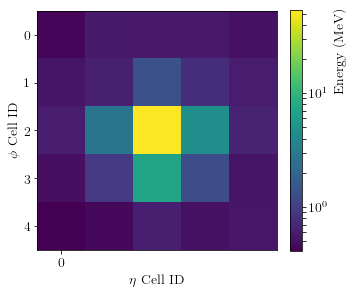

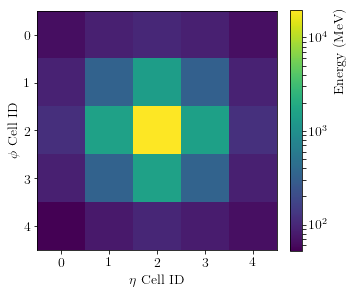

In [13]:
for i in xrange(2):
    plot_image(np.squeeze(test_images_particle[i]).mean(axis=0),
               layer=i,
    )

### GAN model

In [14]:
# input placeholders
latent = Input(shape=(latent_size, ), name='z') # noise
input_energy = Input(shape=(1, ), dtype='float32') # requested energy of the particle shower
generator_inputs = [latent, input_energy]

# multiply the (scaled) energy into the latent space
h = Lambda(lambda x: x[0] * x[1])([latent, scale(input_energy, 100)])

# build three LAGAN-style generators (checkout out `build_generator` in architectures.py)
img_layer0 = build_generator(h, 5, 5)
img_layer1 = build_generator(h, 5, 5)

# outputs
generator_outputs = [
    Activation('relu')(img_layer0),
    Activation('relu')(img_layer1)
    #Activation('relu')(img_layer2)
]

In [15]:
# build the actual model
generator = Model(generator_inputs, generator_outputs)

In [63]:
# load trained weights
generator.load_weights('/Users/elenaorlova/data/params_generator_epoch_039.hdf5')

In [64]:
latent_size = 1024

In [65]:
# 10,000 is the number of showers we want to generate right now
noise = np.random.normal(0, 1, (10000, latent_size))

In [66]:
pr_images = generator.predict([noise, test_energy], verbose=True)

 9984/10000 [============================>.] - ETA: 0s

In [67]:
pr_images = map(lambda x: np.squeeze(x * 1000), pr_images)

In [68]:
pr_images_0 = np.array(pr_images[0])
pr_images_1 = np.array(pr_images[1])

In [69]:
vmin = [test_particle_0.mean(axis=0).min(),  test_particle_1.mean(axis=0).min()]
vmax = [test_particle_0.mean(axis=0).max(),  test_particle_1.mean(axis=0).max()]

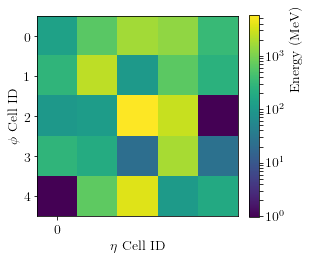

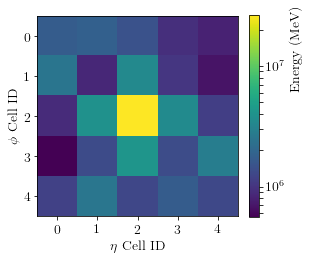

In [70]:
gen_images_particle = [pr_images[0], pr_images[1]]
for i in xrange(2):
    plot_image(np.squeeze(gen_images_particle[i]).mean(axis=0),
               layer=i
               #vmin=vmin[i], vmax=vmax[i]
              )

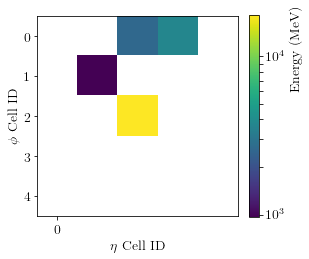

In [71]:
plot_image(pr_images_0[0], layer=0)

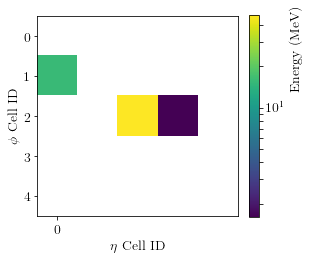

In [72]:
plot_image(test_particle_0[0], layer=0)

In [73]:
c = 0
for i in range(test_particle_0.shape[0]):
    if np.any(test_particle_0[i]) == 0:
        c += 1
print c

461


In [35]:
dgen_particle = {
    'layer_0' : np.squeeze(pr_images[0]),
    'layer_1' : np.squeeze(pr_images[1])
}

# Quantitative Performance Evaluation

Showers can be described using useful, engineered 1d variables, some of them known in the field as "shower shape" variables. These not only help distinguish among the different types of particles, but they also allow us to test how well the GAN is able to reproduce the true data distribution it tried to learn. Not that, besides energy and sparsity, none of these variables were directly built into the network, so the network never knew it had to reproduce them with high fidelity.

In [36]:
from feats1d import *
matplotlib.rcParams.update({'font.size': 30})

In [37]:
colors = matplotlib.cm.gnuplot2(np.linspace(0.2, 0.8, 2))

## Sparsity

In [38]:
gen_sparsity_particle = map(lambda x: (x > 0).mean((1, 2)), [v for v in dgen_particle.itervalues()])
real_sparsity_particle = map(lambda x: (x > 0).mean((1, 2)), test_images_particle)

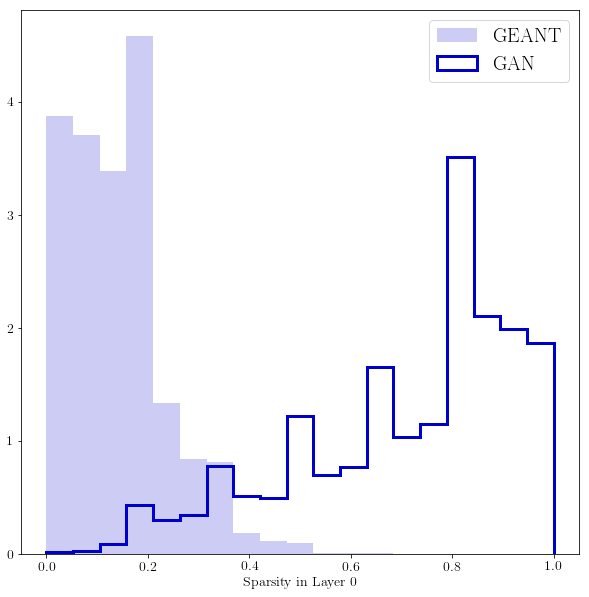

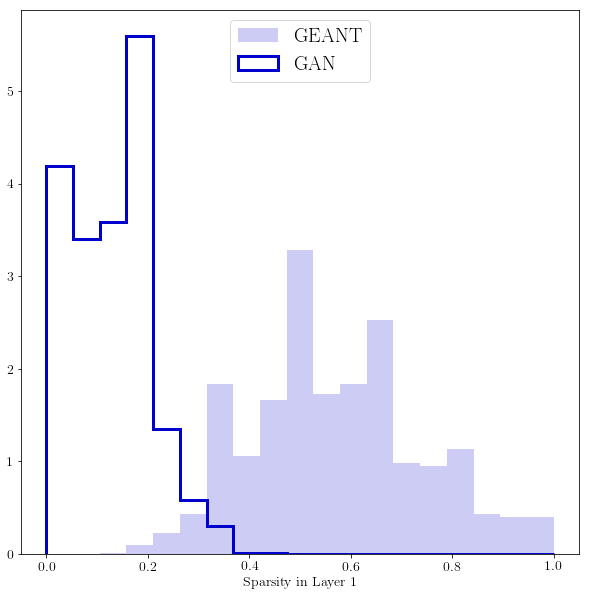

In [39]:
for i in xrange(2):
    bins = np.linspace(0, 1, 20)
    plt.figure(figsize=(10, 10))
    _ = plt.hist(real_sparsity_particle[i], bins=bins, histtype='stepfilled', linewidth=2,
                 alpha=0.2, normed='True', color=colors[0],
                 label=r' GEANT')
    _ = plt.hist(gen_sparsity_particle[i], bins=bins, histtype='step', linewidth=3,
                 alpha=1, normed='True', color=colors[0],
                 label=r' GAN')
    if i==1:
        loc='upper center'
    else:
        loc = 'upper right'
    plt.legend(loc=loc, ncol=1, fontsize=20)#, mode='expand', fontsize=20)
    plt.xlabel('Sparsity in Layer {}'.format(i))
    #plt.savefig('sparsity_layer{}.pdf'.format(i))

## Depth

In [40]:
def my_depth(d):
    maxdepth = 1 * (d['layer_1'][:].sum(axis=(1, 2)) != 0) 
    maxdepth[maxdepth == 0] = 1 * (d['layer_1'][:][maxdepth == 0].sum(axis=(1, 2)) != 0) 
    return maxdepth

In [41]:
depth_orig_particle = my_depth(test_particle)
depth_gen_particle = my_depth(dgen_particle)

In [42]:
pr_images_0 = np.array(pr_images[0])
pr_images_1 = np.array(pr_images[1])

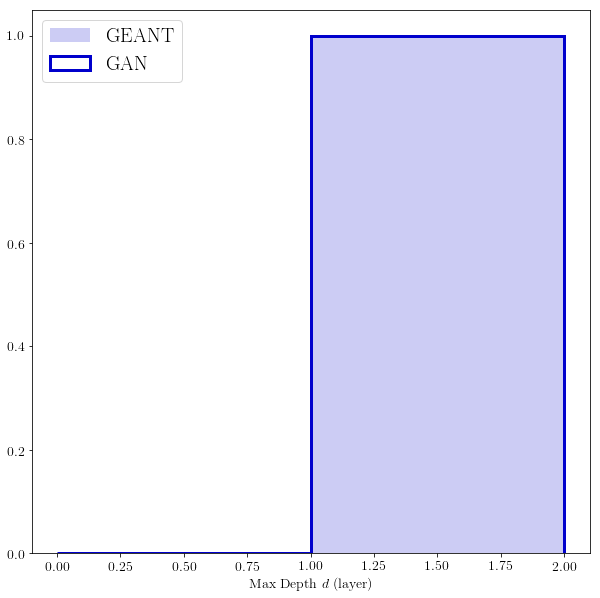

In [43]:
bins = [0, 1, 2]

plt.figure(figsize=(10, 10))
_ = plt.hist(depth_orig_particle, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r' GEANT')
_ = plt.hist(depth_gen_particle, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r' GAN')

# _ = plt.hist(depth_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
# _ = plt.hist(depth_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.legend(loc='upper left', fontsize=20)
plt.xlabel(r'Max Depth $d$ (layer)')
#plt.savefig('max_layer_depth.pdf')

## Total Energy

In [74]:
etot_orig_particle = total_energy(test_particle)
etot_gen_particle = total_energy(dgen_particle)

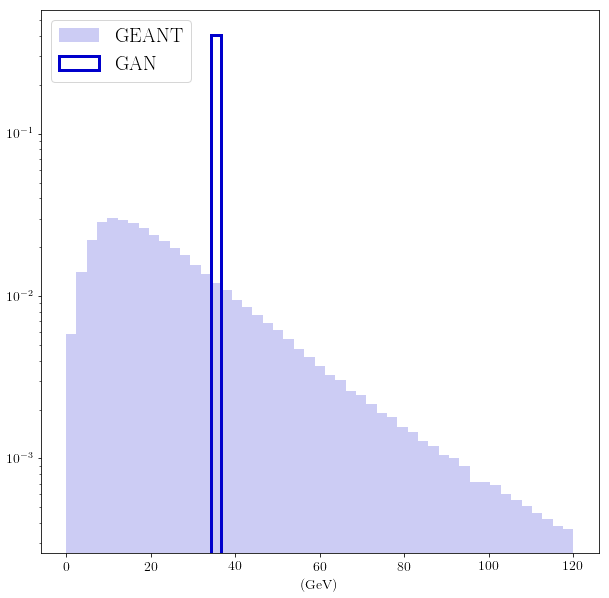

In [75]:
bins = np.linspace(0, 120, 50)
plt.figure(figsize=(10, 10))
_ = plt.hist(etot_orig_particle / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r' GEANT')
_ = plt.hist(etot_gen_particle / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r' GAN')
plt.legend(loc='upper left', fontsize=20, ncol=1)
plt.yscale('log')
plt.xlabel(r' (GeV)')
#plt.savefig('etot.pdf')

## Energy per Layer

In [46]:
e1_orig_particle = energy('1', test_particle)
e1_gen_particle = energy('1', dgen_particle) 
e0_orig_particle = energy('0', test_particle)
e0_gen_particle = energy('0', dgen_particle)


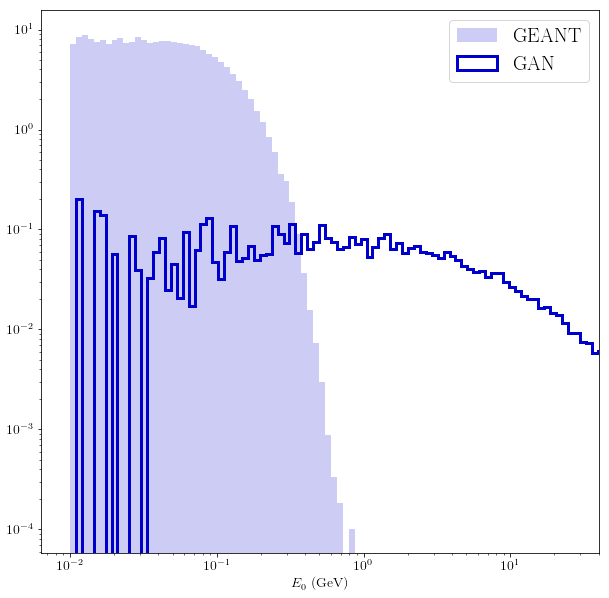

In [47]:
bins=np.logspace(-2, 2, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig_particle / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r' GEANT')
_ = plt.hist(e0_gen_particle / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r' GAN')
plt.yscale('log')
plt.xscale('log')
plt.xlim(xmax=40)
plt.legend(loc='upper right', ncol=1, fontsize=20)

plt.xlabel(r'$E_0$ (GeV)')
#plt.savefig('e0_loglog.pdf')

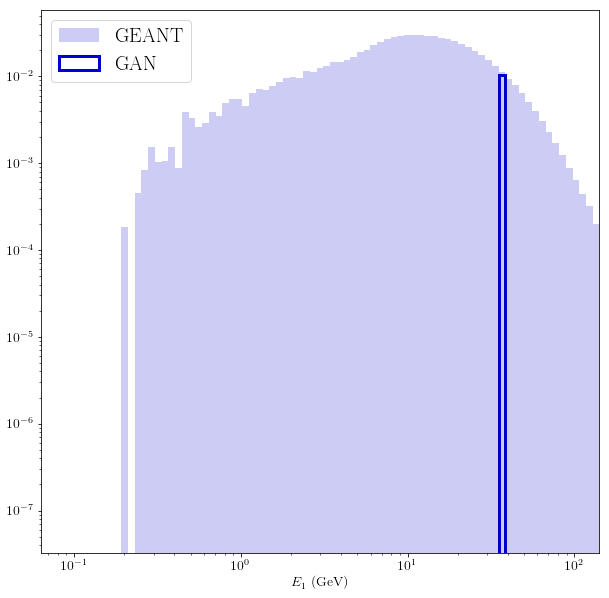

In [48]:
bins=np.logspace(-1, 3, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e1_orig_particle / 1000, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'GEANT')
_ = plt.hist(e1_gen_particle / 1000, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'GAN')
plt.yscale('log')
plt.xscale('log')
plt.xlim(xmax=140)

plt.legend(loc='upper left', ncol=1, fontsize=20)
plt.xlabel(r'$E_1$ (GeV)')
#plt.savefig('e1_loglog.pdf')

## Energy Fractions

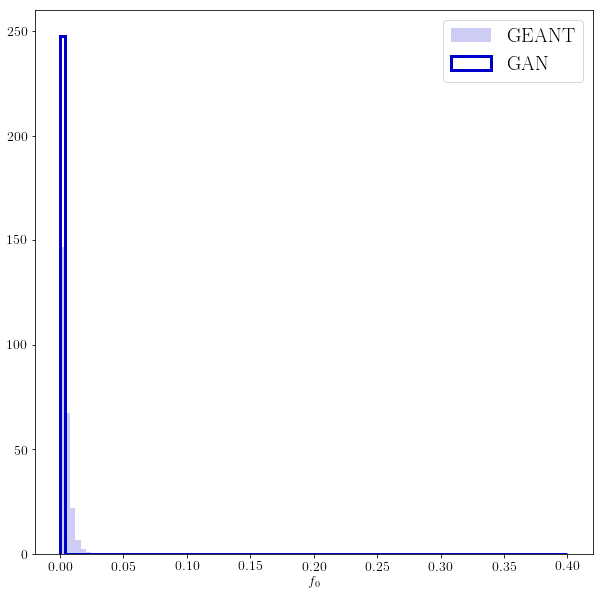

In [49]:
bins = np.linspace(0, 0.4, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig_particle / etot_orig_particle, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'GEANT')
_ = plt.hist(e0_gen_particle / etot_gen_particle, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'GAN')
plt.legend(loc='upper right', ncol=1, fontsize=20)

plt.xlabel(r'$f_0$')#$E_0 / E_\mathrm{tot}$')
#plt.savefig('e0_etot.pdf')

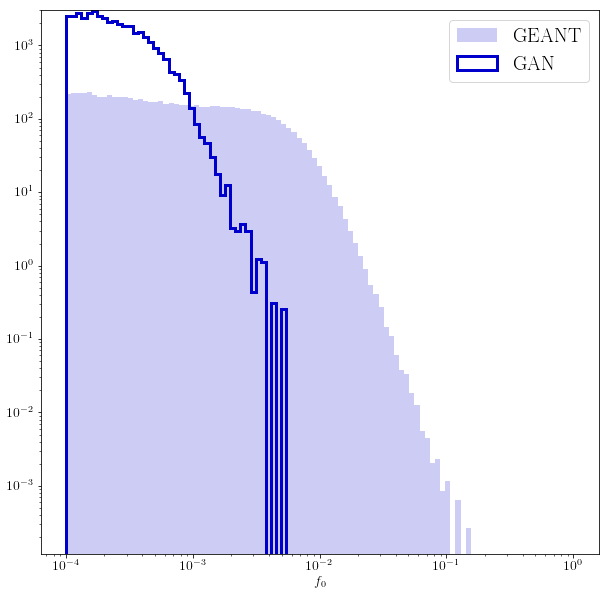

In [50]:
bins = np.logspace(-4, 0, 100) #np.linspace(0, 0.4, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(e0_orig_particle / etot_orig_particle, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'GEANT')
_ = plt.hist(e0_gen_particle / etot_gen_particle, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'GAN')
plt.legend(loc='upper right', ncol=1, fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.ylim(ymax=3000)
plt.xlabel(r'$f_0$')#$E_0 / E_\mathrm{tot}$')
#plt.savefig('e0_etot_loglog.pdf')

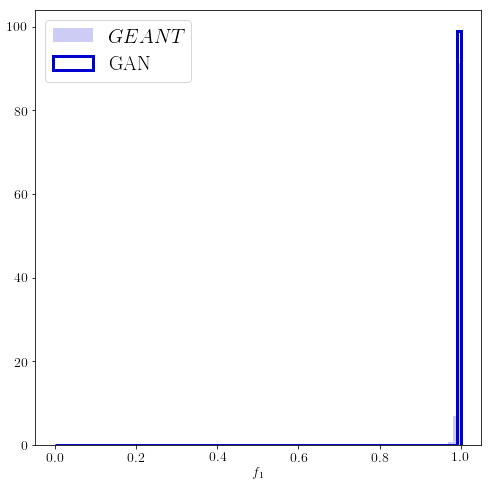

In [51]:
bins = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 8))
_ = plt.hist(e1_orig_particle / etot_orig_particle, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$ GEANT')
_ = plt.hist(e1_gen_particle / etot_gen_particle, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r' GAN')
plt.legend(loc='upper left', ncol=1, fontsize=20)

plt.xlabel(r'$f_1$')#$E_1 / E_\mathrm{tot}$')
#plt.savefig('e1_etot.pdf')

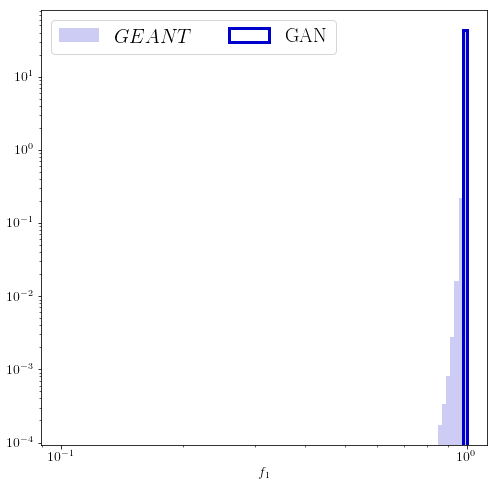

In [52]:
bins=np.logspace(-1, 0, 100)
plt.figure(figsize=(8, 8))
_ = plt.hist(e1_orig_particle / etot_orig_particle, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$ GEANT')
_ = plt.hist(e1_gen_particle / etot_gen_particle, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r' GAN')
plt.legend(loc='upper left', ncol=2, fontsize=20)
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$f_1$')#$E_1 / E_\mathrm{tot}$')
#plt.savefig('e1_etot_loglog.pdf')

## Shower Depth

In [53]:
lateral_depth_orig_particle = lateral_depth(test_particle)
lateral_depth_gen_particle = lateral_depth(dgen_particle)

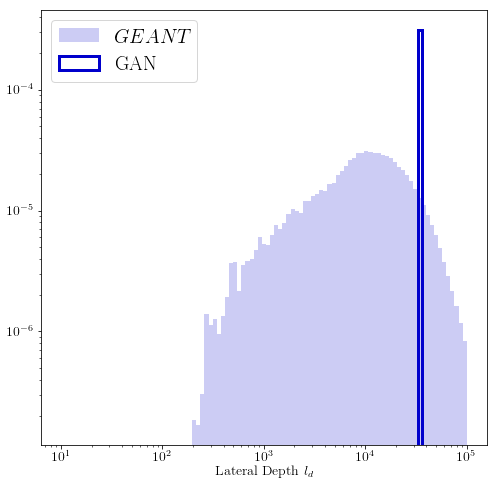

In [54]:
# shower depth
bins = np.logspace(1, 5, 100)#np.linspace(0, 120000, 100)
plt.figure(figsize=(8, 8))

_ = plt.hist(lateral_depth_orig_particle, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'$ GEANT')
_ = plt.hist(lateral_depth_gen_particle, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r' GAN')
plt.legend(loc='upper left', ncol=1, fontsize=20)
plt.yscale('log')
plt.xscale('log')

plt.xlabel(r'Lateral Depth $l_d$')
#plt.savefig('lateral_depth.pdf')

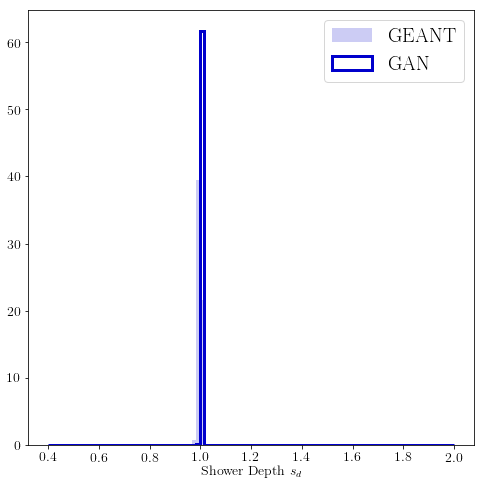

In [55]:
bins = np.linspace(0.4, 2, 100)
plt.figure(figsize=(8, 8))
_ = plt.hist(lateral_depth_orig_particle / etot_orig_particle, bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'GEANT')
_ = plt.hist(lateral_depth_gen_particle / etot_gen_particle, bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'GAN')

plt.legend(loc='upper right', ncol=1, fontsize=20)

# _ = plt.hist(lateral_depth_orig / etot_orig, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GEANT')
# _ = plt.hist(lateral_depth_gen / etot_gen, bins=bins, histtype='stepfilled', alpha=0.5, normed='True', label='GAN')
plt.xlabel(r'Shower Depth $s_d$')
#plt.savefig('shower_depth.pdf')

## Lateral Width per Layer

In [56]:
lateral_width0_orig_particle = layer_lateral_width('0', test_particle)
lateral_width1_orig_particle = layer_lateral_width('1', test_particle)
lateral_width0_gen_particle = layer_lateral_width('0', dgen_particle)
lateral_width1_gen_particle = layer_lateral_width('1', dgen_particle)

feats1d.py:119: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((x2 / (e + 1e-7)) - (x / (e + 1e-7)) ** 2)


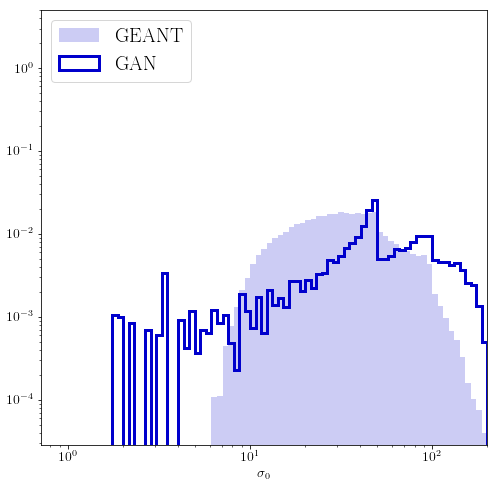

In [57]:
# layer 0 lateral width
bins = np.logspace(0, 3, 100)#np.linspace(0, 100, 100)
plt.figure(figsize=(8, 8))
_ = plt.hist(lateral_width0_orig_particle[np.isfinite(lateral_width0_orig_particle)],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r' GEANT')
_ = plt.hist(lateral_width0_gen_particle[np.isfinite(lateral_width0_gen_particle)],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r' GAN')

plt.legend(loc='upper left', ncol=1, fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.ylim(ymax=5)
plt.xlim(xmax=200)
plt.xlabel(r'$\sigma_0$')
#plt.savefig('lateral_width_layer0.pdf')

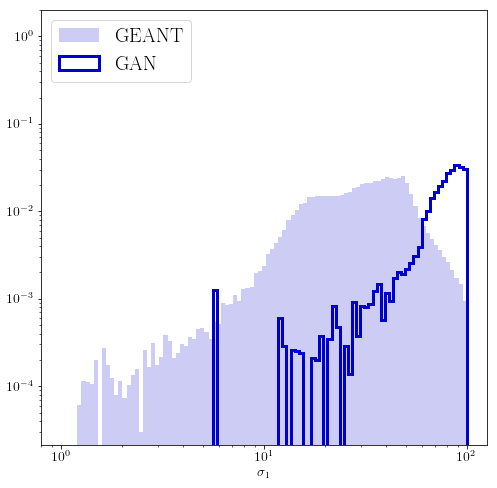

In [58]:
# layer 1 lateral width
bins = np.logspace(0, 2, 100)#np.linspace(0, 70, 100)
plt.figure(figsize=(8, 8))
_ = plt.hist(lateral_width1_orig_particle[np.isfinite(lateral_width1_orig_particle)],
             bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'GEANT')
_ = plt.hist(lateral_width1_gen_particle[np.isfinite(lateral_width1_gen_particle)],
             bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'GAN')
plt.legend(loc='upper left', ncol=1, fontsize=20)
plt.xscale('log')
plt.yscale('log')
plt.ylim(ymax=2)
plt.xlabel(r'$\sigma_1$')
#plt.savefig('lateral_width_layer1.pdf')

## E_ratio

In [59]:
def eratio(images):
    top2 = np.array([np.sort(row.ravel())[::-1][:2] for row in images])
    top2[top2 < 1e-10] = 1e-10
    return (top2[:, 0] - top2[:, 1]) / (top2[:, 0] + top2[:, 1])

In [60]:
eratio(pr_images[0])

array([ 0.79957592,  0.22526787,  0.69365788, ...,  0.5752703 ,
        0.734864  ,  1.        ], dtype=float32)

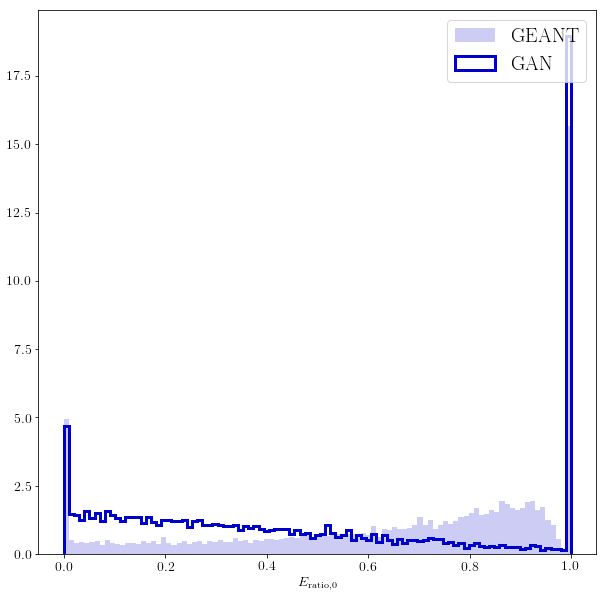

In [61]:
#bins=np.logspace(-2, 2, 100)
bins=np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(eratio(test_images_particle[0]), bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r' GEANT')
_ = plt.hist(eratio(dgen_particle['layer_0']), bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r' GAN')
plt.legend(loc='upper right', ncol=1, fontsize=20)

plt.xlabel(r'$E_{\mathrm{ratio},0}$')
#plt.savefig('eratio.pdf')

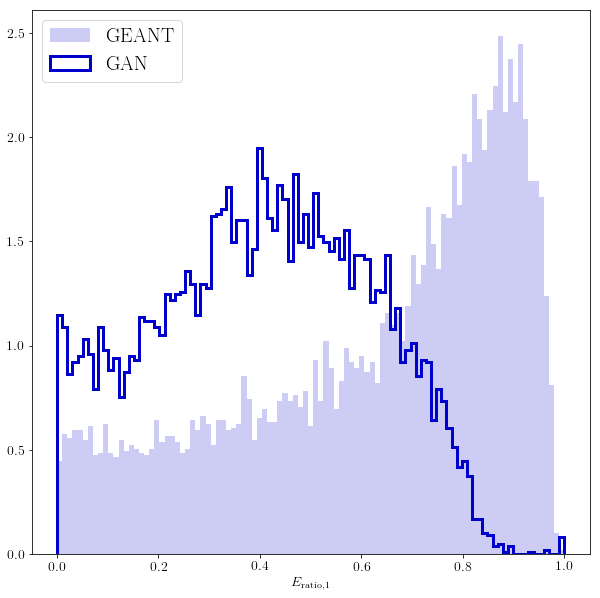

In [62]:
#bins=np.logspace(-2, 2, 100)
bins=np.linspace(0, 1, 100)
plt.figure(figsize=(10, 10))
_ = plt.hist(eratio(test_images_particle[1]), bins=bins, histtype='stepfilled', linewidth=2,
             alpha=0.2, normed='True', color=colors[0],
             label=r'GEANT')
_ = plt.hist(eratio(dgen_particle['layer_1']), bins=bins, histtype='step', linewidth=3,
             alpha=1, normed='True', color=colors[0],
             label=r'GAN')
plt.legend(loc='upper left', ncol=1, fontsize=20)

plt.xlabel(r'$E_{\mathrm{ratio},1}$')
#plt.savefig('eratio1.pdf')